<a href="https://colab.research.google.com/github/omvir-12/Alzheimer-s-Disease-Stage-Classification-from-Brain-MRI/blob/main/Alzheimer's_Model_EFFICIENTNETB3_100_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aryansinghal10_alzheimers_multiclass_dataset_equal_and_augmented_path = kagglehub.dataset_download('aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented')

print('Data source import complete.')


100%|██████████| 398M/398M [00:06<00:00, 65.5MB/s]

Extracting files...


Data source import complete.


Alzheimer’s disease is a progressive neurodegenerative disorder that causes structural changes in the brain, such as cortical thinning and ventricular enlargement. Magnetic Resonance Imaging (MRI) provides a non-invasive way to capture these changes, making it a valuable tool for early diagnosis and disease staging.

In this notebook, I present an end-to-end deep learning pipeline that classifies Alzheimer’s disease stages from brain MRI images using Convolutional Neural Networks (CNNs) and transfer learning with Efficienetb3. The model is trained to distinguish between four classes representing different stages of cognitive impairment.

# Import Required Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Configuration

In [ ]:
IMG_SIZE = (300, 300)
BATCH = 64  # Increased batch size
NUM_CLASSES = 4
EPOCHS = 200
DATASET_DIR = "/Users/rupali.rhatol/Desktop/Datasets/combined_images"
CLASS_NAMES = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

os.makedirs("outputs", exist_ok=True)

# Load Dataset

In [ ]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

# Convert to numpy for stratified split
all_images, all_labels = [], []
for imgs, labels in full_ds:
    all_images.append(imgs.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Stratified split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])

# Data Augmentation

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator()

train_ds = train_gen.flow(X_train, y_train, batch_size=BATCH)
val_ds = val_gen.flow(X_val, y_val, batch_size=BATCH)

# Build EfficienetB3 Model

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
)
base_model.trainable = False  # Phase 1: freeze base

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks

In [ ]:
checkpoint = ModelCheckpoint("outputs/best_model.h5", save_best_only=True, monitor="val_accuracy")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Phase 1 Training (Base Frozen)

In [ ]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Phase 2 Fine-Tune (Base Unfrozen)

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-100]:  # Freeze first 100 layers
    layer.trainable = False

# Adjusted learning rate for large batch
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS-50,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Plot Training Curves

In [ ]:
train_acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
train_loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

# 2D plots
plt.figure(figsize=(12,6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training & Validation Accuracy / Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.savefig("outputs/training_curves.png")
plt.close()

# 3D surface plot for accuracy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.arange(len(train_acc))
Y = np.array([0]*len(train_acc) + [1]*len(val_acc))[:len(train_acc)]
Z = np.array(train_acc + val_acc)
ax.plot_trisurf(X, Y, Z, cmap=cm.viridis, linewidth=0.2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Train/Val")
ax.set_zlabel("Accuracy")
ax.set_title("3D Surface of Accuracy")
plt.savefig("outputs/accuracy_surface_3d.png")
plt.close()

# 3D surface plot for loss
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Z_loss = np.array(train_loss + val_loss)
ax.plot_trisurf(X, Y, Z_loss, cmap=cm.plasma, linewidth=0.2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Train/Val")
ax.set_zlabel("Loss")
ax.set_title("3D Surface of Loss")
plt.savefig("outputs/loss_surface_3d.png")
plt.close()

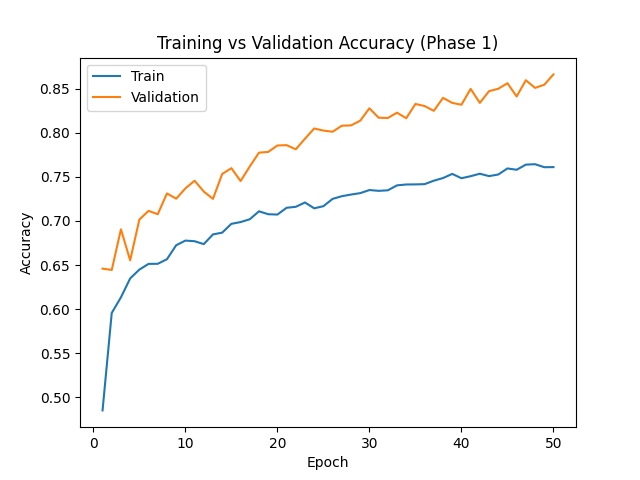

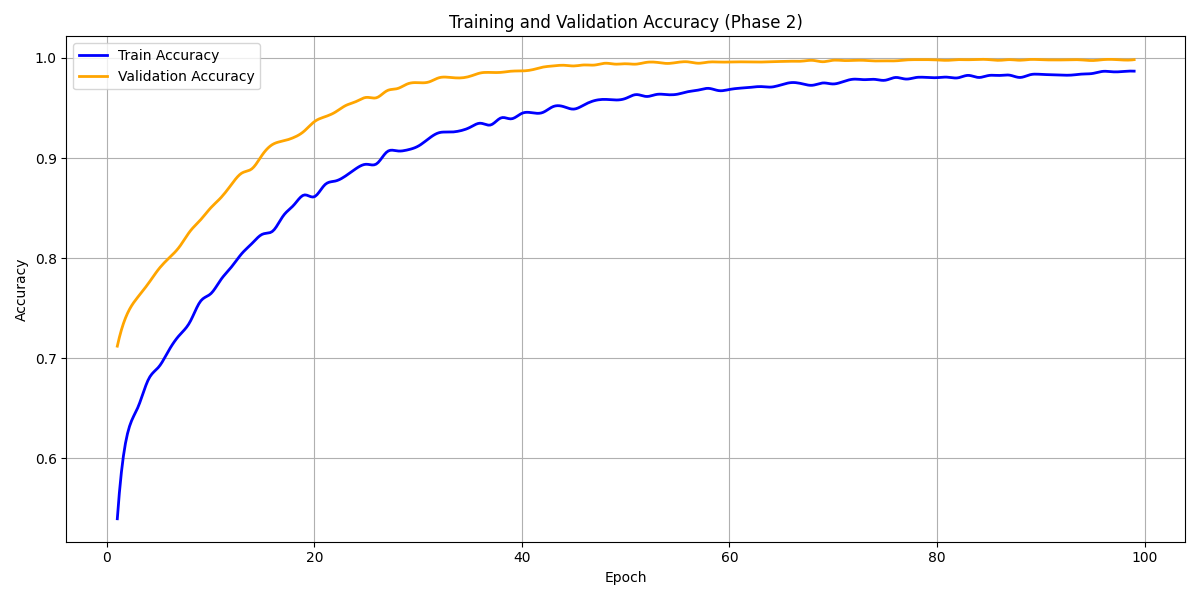

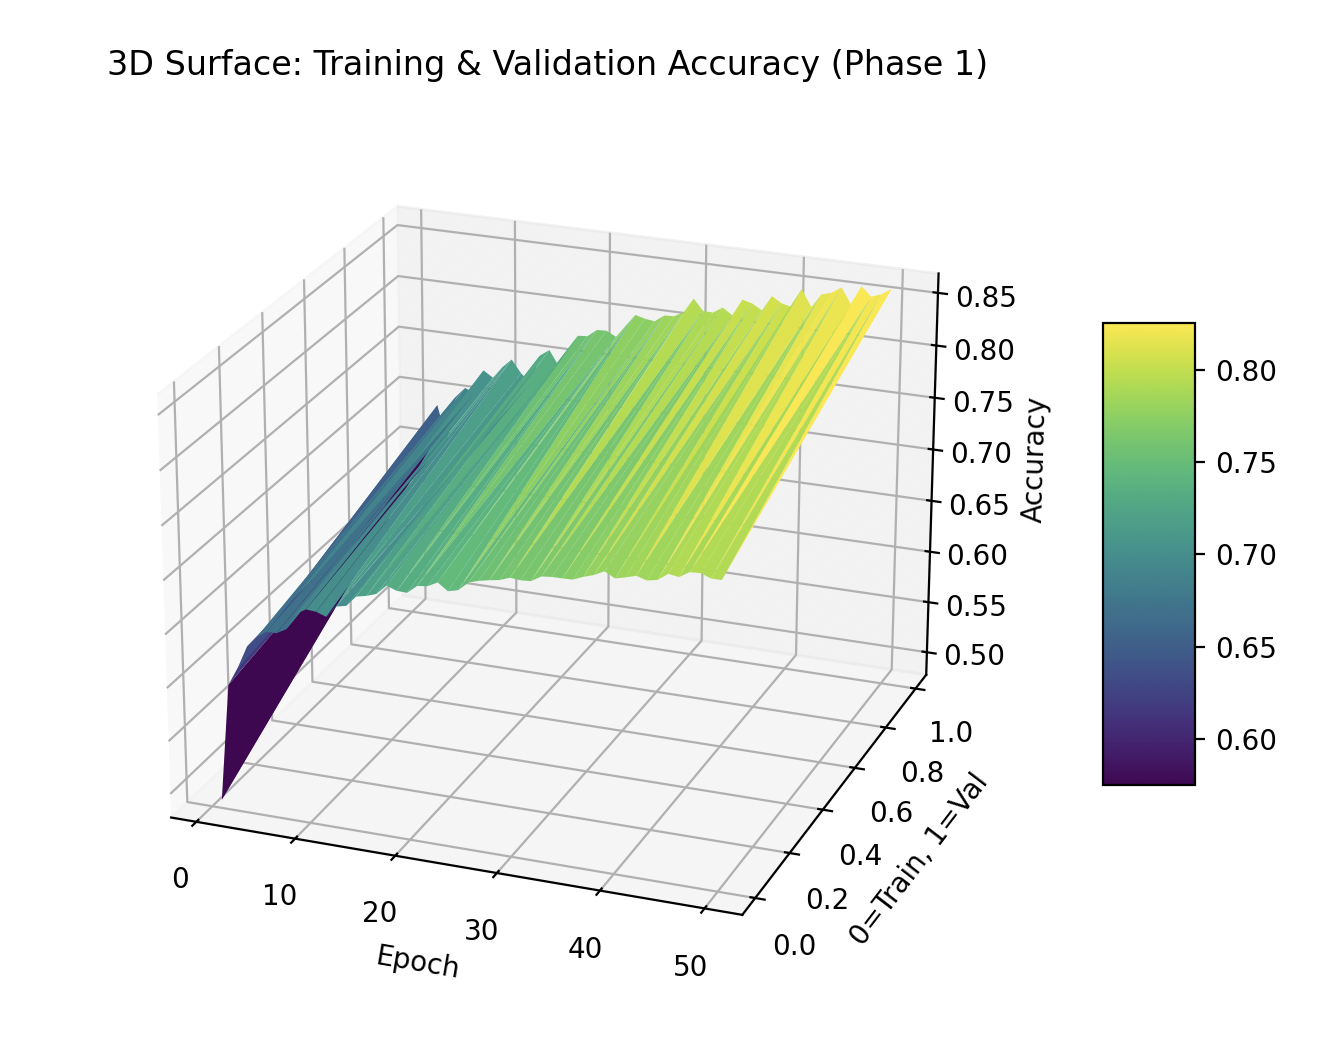

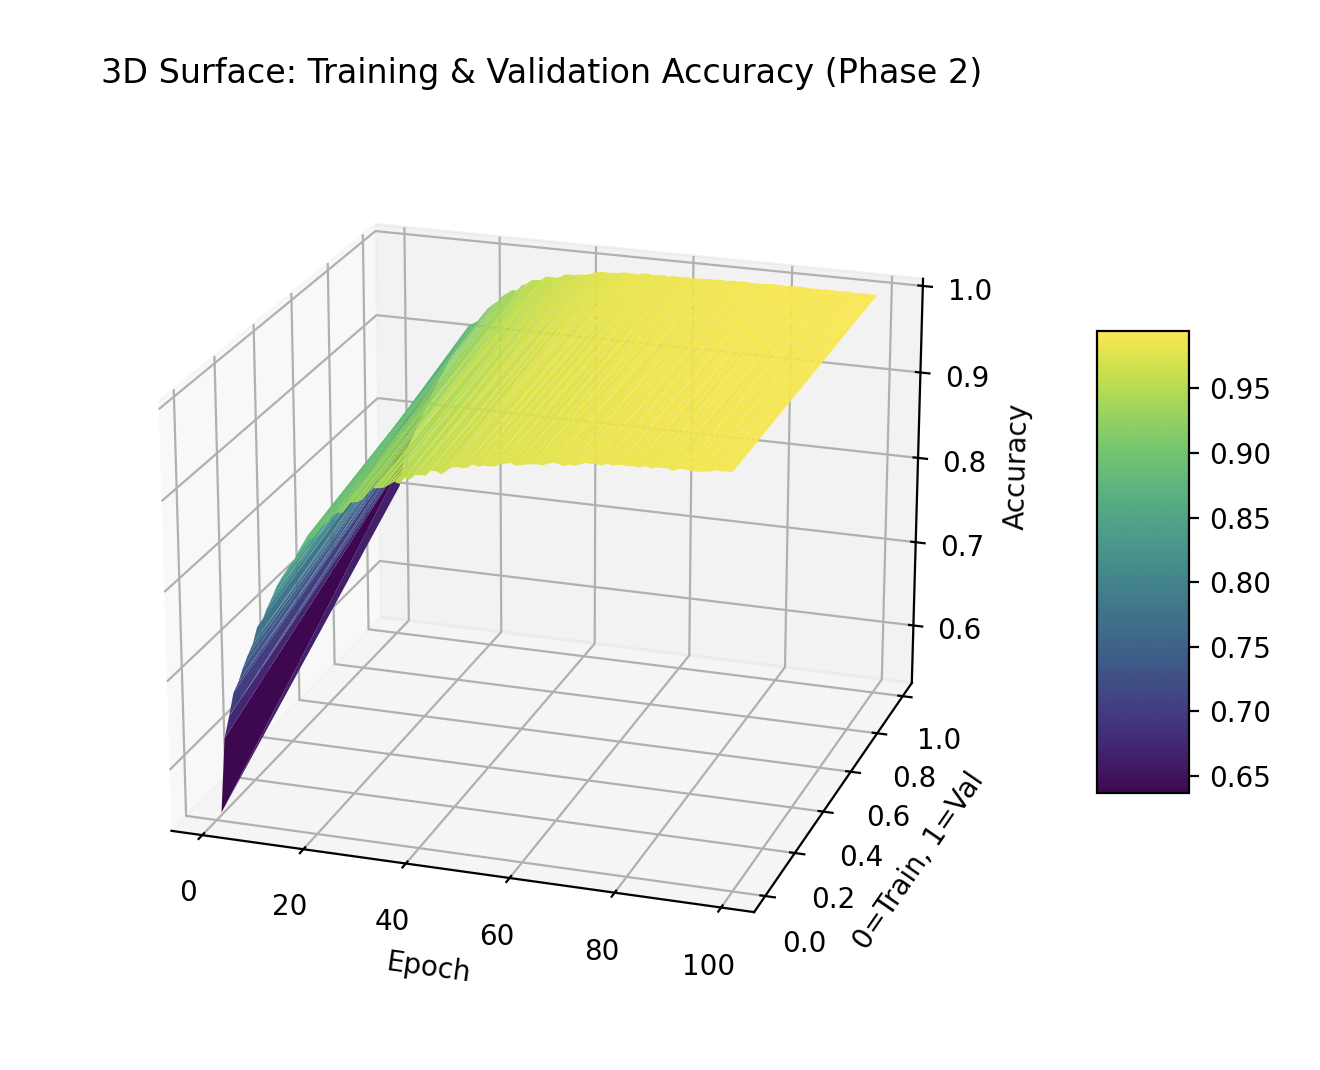

# Evaluate Test Set

In [ ]:
model.load_weights("outputs/best_model.h5")
y_true, y_pred = [], []
for imgs, labels in tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH):
    preds = model.predict(imgs)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion matrix 2D
cm_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_matrix, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.savefig("outputs/confusion_matrix.png")
plt.close()

# 3D confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.bar3d(i, j, 0, 0.5, 0.5, cm_matrix[i,j], shade=True)
ax.set_xticks(np.arange(len(CLASS_NAMES))+0.25)
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticks(np.arange(len(CLASS_NAMES))+0.25)
ax.set_yticklabels(CLASS_NAMES)
ax.set_zlabel('Count')
ax.set_title("3D Confusion Matrix")
plt.savefig("outputs/confusion_matrix_3d.png")
plt.close()

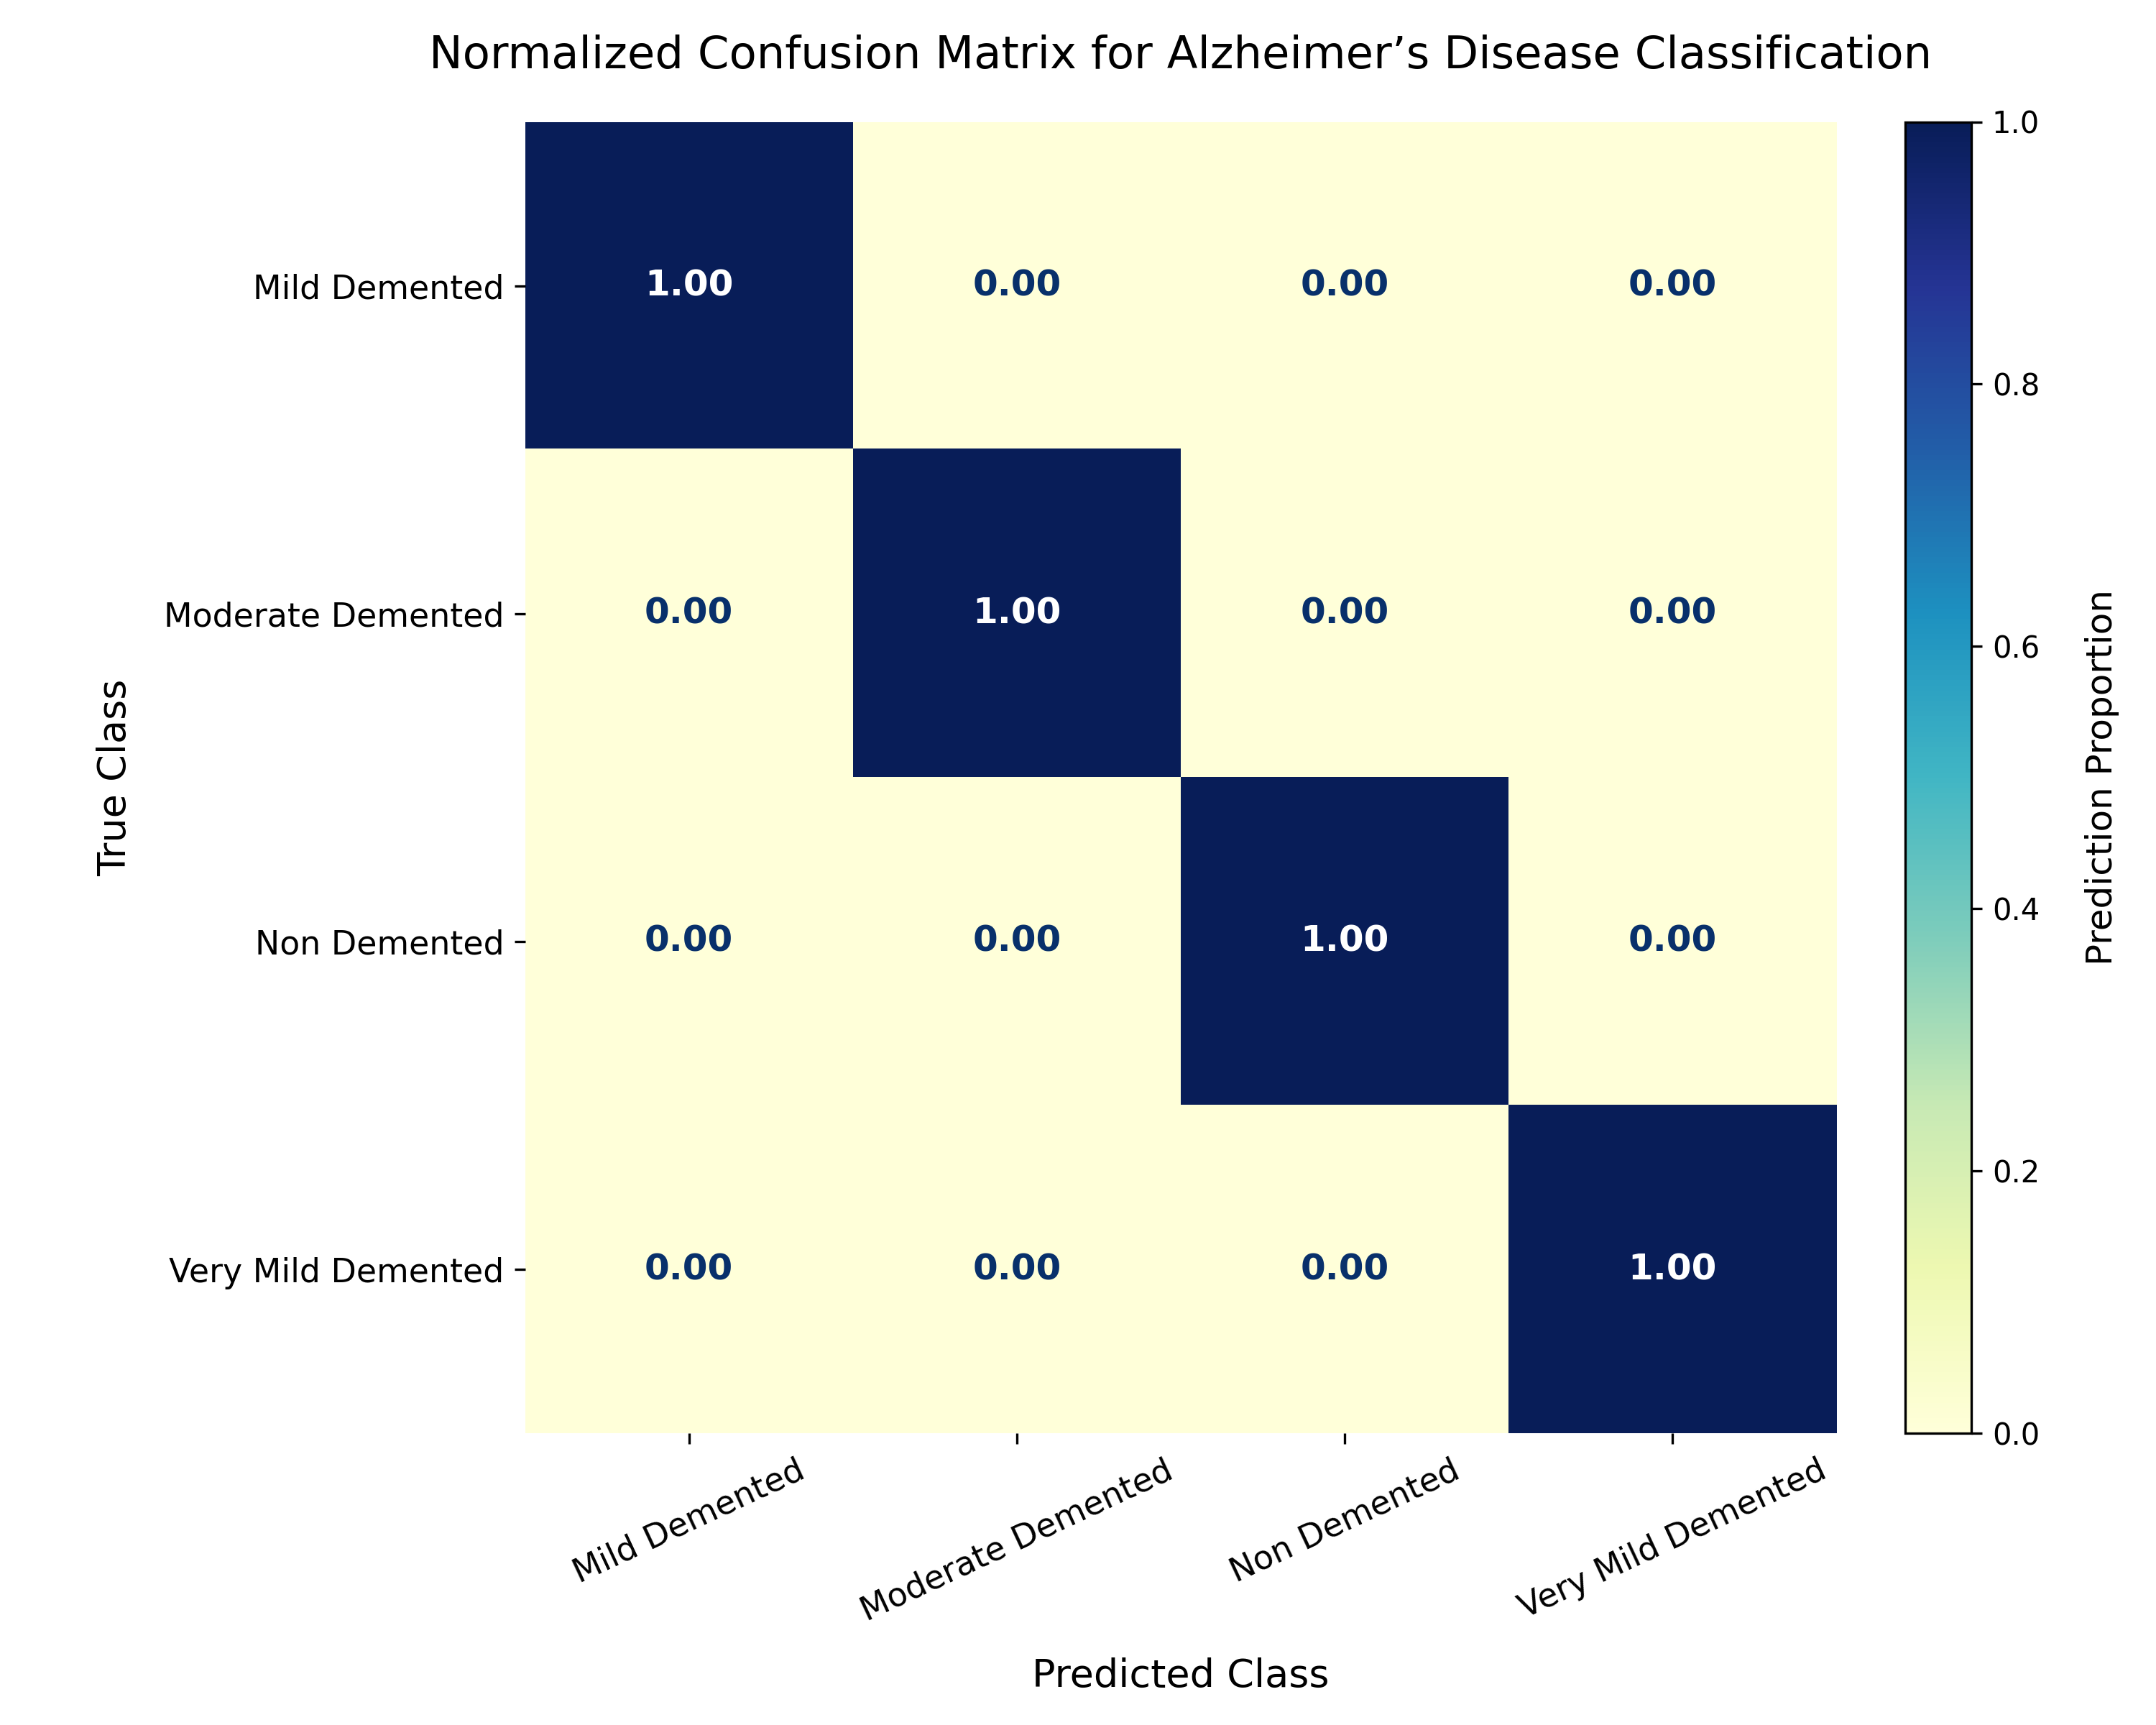

# Sample Images Per Class

In [ ]:
for i, cls in enumerate(CLASS_NAMES):
    idxs = np.where(np.argmax(y_train, axis=1) == i)[0]
    plt.figure(figsize=(12,4))
    for j in range(min(8, len(idxs))):
        plt.subplot(1,8,j+1)
        plt.imshow(X_train[idxs[j]].astype("uint8"))
        plt.axis("off")
        plt.title(cls)
    plt.suptitle(f"Sample Training Images for {cls}")
    plt.savefig(f"outputs/sample_images_{cls}.png")
    plt.close()

print("Strong EfficientNetB3 training complete with batch=64. All outputs and 3D plots saved.")

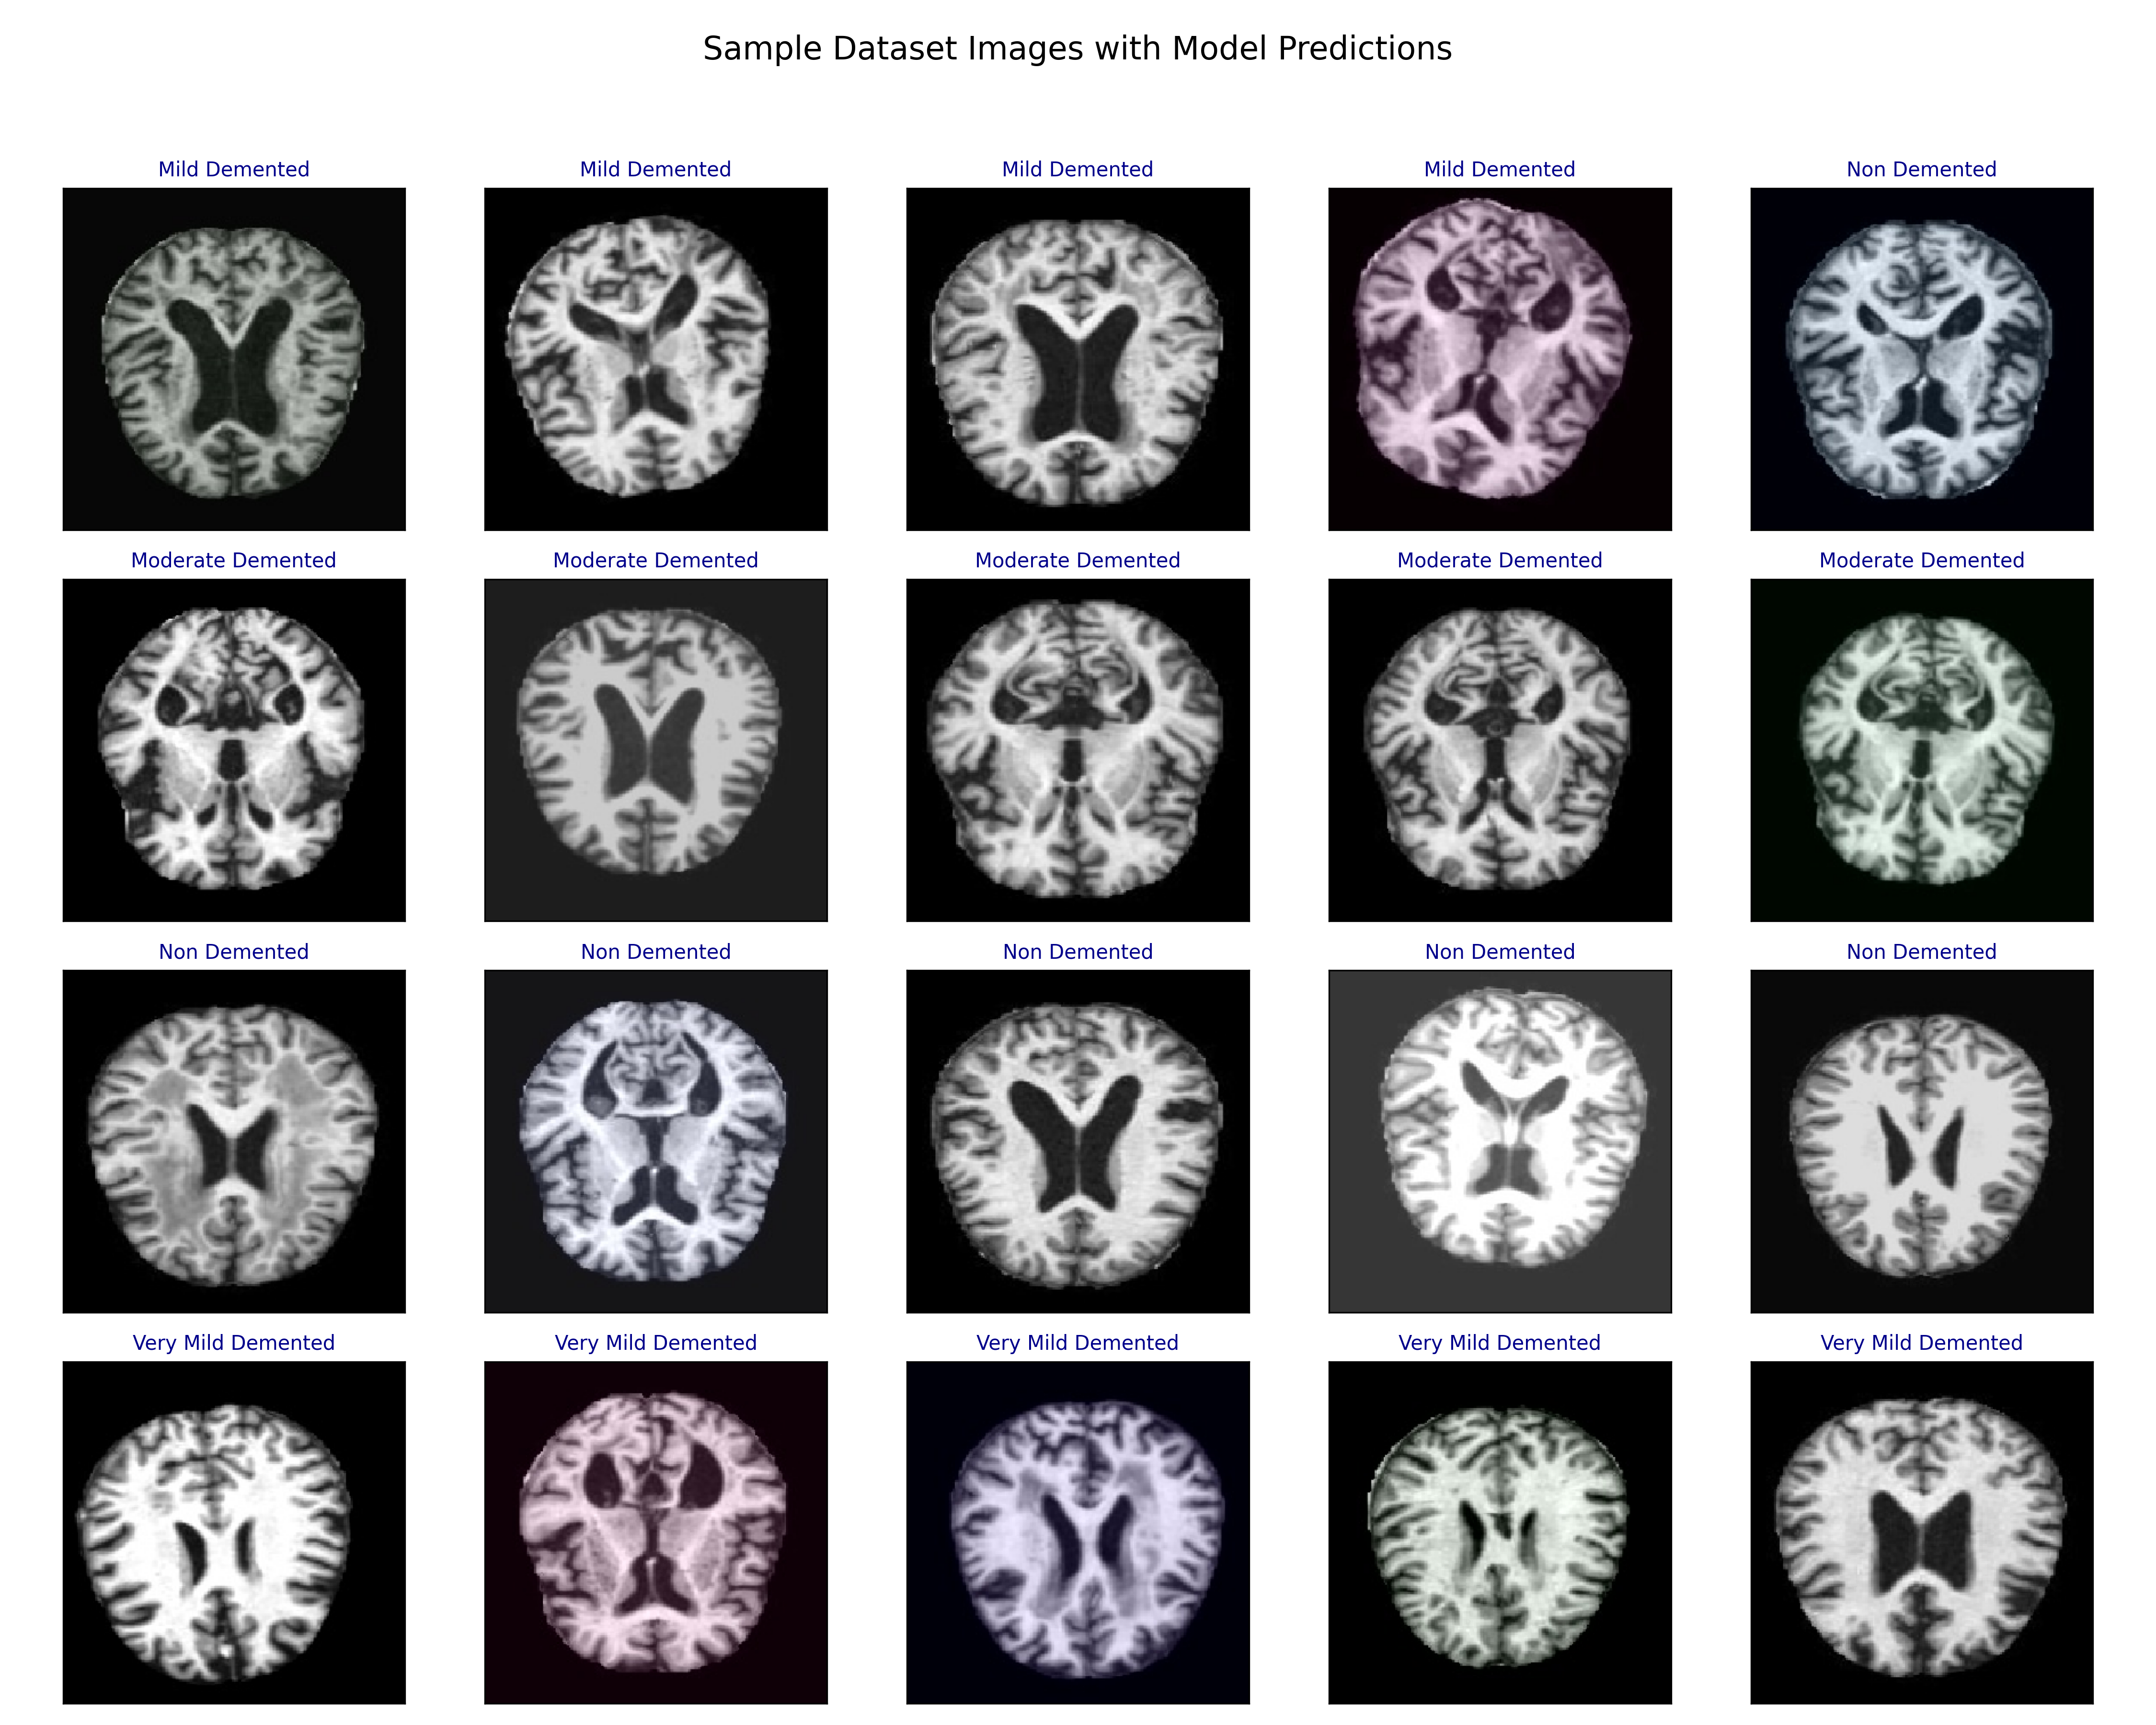